# Momentum-Variance Phase Space (Crucible 2)

The AdamW update rule determines whether a token can hop:

$$\Delta W = \frac{\eta \cdot m}{\sqrt{v} + \epsilon}$$

A token hops when |ΔW| ≥ ULP. The critical boundary is:

$$|m| = \frac{\text{ULP} \cdot (\sqrt{v} + \epsilon)}{\eta}$$

**Key finding from earlier analysis:** The "cohort" that transitions together at step 396-397 isn't spatially clustered in (m, v) space. They're at the same distance from the critical boundary as everyone else. The cohort is a *threshold-crossing event*, not a spatial cluster—like a wave breaking, everyone near the waterline gets wet at the same moment.

**This notebook explores:**
1. Population dynamics in (√v, |m|) phase space
2. Distance to critical boundary over time
3. Gradient structure at the transition
4. Individual token trajectories

## Setup

In [1]:
import torch
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# Paths
INPUT_PATH = '../../tensors/Crucible-2/crucible_2_trajectory.safetensors'

# AdamW hyperparameters (from Crucible 2)
ETA = 1e-3
EPSILON = 1e-8

# Plotting
DPI = 150
FIGSIZE = (12, 8)
FIGSIZE_WIDE = (14, 6)

np.random.seed(42)

## Load Data

In [2]:
data = load_file(INPUT_PATH)

W = data['W'].view(torch.bfloat16)  # (501, 3699, 64)
m = data['m']  # (501, 3699, 64) float32
v = data['v']  # (501, 3699, 64) float32
g = data['g']  # (500, 3699, 64) float32
delta_W_prime = data['delta_W_prime']  # (500, 3699, 64) float32

n_steps = 500
n_tokens = 3699
n_dims = 64

print(f"Loaded Crucible 2 data:")
print(f"  Steps: {n_steps}")
print(f"  Tokens: {n_tokens}")
print(f"  Dims: {n_dims}")

Loaded Crucible 2 data:
  Steps: 500
  Tokens: 3699
  Dims: 64


## Compute Scalar Summaries

For phase space visualization, we collapse the 64-dimensional vectors to scalars:
- |m|: L2 norm of momentum
- √v: square root of mean variance across dimensions
- ULP: mean ULP across dimensions

In [3]:
def compute_ulp_bf16(tensor_bf16):
    """Compute ULP for each element of a bfloat16 tensor."""
    bits = tensor_bf16.view(torch.uint16).to(torch.int32)
    exponent = (bits >> 7) & 0xFF
    effective_exp = torch.where(exponent == 0, torch.ones_like(exponent), exponent)
    ulp = torch.pow(2.0, (effective_exp - 134).float())
    return ulp

# Compute per-token, per-step scalars (using state AFTER each step, so indices 1:501)
m_norm = torch.norm(m[1:], dim=2)  # (500, 3699) - |m| after each step
v_mean = v[1:].mean(dim=2)  # (500, 3699) - mean v after each step
sqrt_v = torch.sqrt(v_mean)

# ULP at W before each step (indices 0:500)
ulp_all = compute_ulp_bf16(W[:-1])  # (500, 3699, 64)
ulp_mean = ulp_all.mean(dim=2)  # (500, 3699)

# Gradient norm
g_norm = torch.norm(g, dim=2)  # (500, 3699)

print(f"|m| range: [{m_norm.min():.2e}, {m_norm.max():.2e}]")
print(f"√v range: [{sqrt_v.min():.2e}, {sqrt_v.max():.2e}]")
print(f"ULP range: [{ulp_mean.min():.2e}, {ulp_mean.max():.2e}]")
print(f"|g| range: [{g_norm.min():.2e}, {g_norm.max():.2e}]")

|m| range: [1.32e-05, 8.18e-04]
√v range: [1.48e-06, 2.02e-05]
ULP range: [5.84e-05, 5.95e-04]
|g| range: [1.14e-05, 1.23e-03]


## Critical Boundary

A token hops when:
$$\frac{\eta \cdot |m|}{\sqrt{v} + \epsilon} \geq \text{ULP}$$

The boundary (|ΔW| = 1 ULP) is:
$$|m|_{\text{critical}} = \frac{\text{ULP} \cdot (\sqrt{v} + \epsilon)}{\eta}$$

In [4]:
def critical_m(sqrt_v, ulp_val, eta=ETA, eps=EPSILON):
    """Critical |m| value for hopping given sqrt(v) and ULP."""
    return ulp_val * (sqrt_v + eps) / eta

# Critical boundary for each token at each step
m_critical = critical_m(sqrt_v, ulp_mean)  # (500, 3699)

# Ratio to critical: >1 means can hop, <1 means frozen
ratio_to_critical = m_norm / m_critical  # (500, 3699)

print(f"Ratio to critical range: [{ratio_to_critical.min():.4f}, {ratio_to_critical.max():.4f}]")
print(f"Mean ratio at step 1: {ratio_to_critical[0].mean():.4f}")
print(f"Mean ratio at step 500: {ratio_to_critical[-1].mean():.4f}")

Ratio to critical range: [2.5716, 828.7082]
Mean ratio at step 1: 282.6921
Mean ratio at step 500: 3.0861


## Identify Hopping vs Frozen

Use actual displacement to determine who hopped (not just phase space prediction).

In [5]:
# L1 displacement (for stumbling detection)
disp_l1 = torch.abs(delta_W_prime).sum(dim=2)  # (500, 3699)
disp_l1 = torch.where(torch.isfinite(disp_l1), disp_l1, torch.zeros_like(disp_l1))

# L2 displacement
disp_l2 = torch.norm(delta_W_prime, dim=2)  # (500, 3699)
disp_l2 = torch.where(torch.isfinite(disp_l2), disp_l2, torch.zeros_like(disp_l2))

# Classifications
is_stumbling = disp_l1 <= 1.0  # L1 <= 1
is_frozen = disp_l1 == 0  # No motion at all
is_hopping = disp_l1 > 1.0  # Multi-cell motion

print(f"Hopping fraction at step 1: {is_hopping[0].float().mean():.1%}")
print(f"Hopping fraction at step 500: {is_hopping[-1].float().mean():.1%}")
print(f"Stumbling fraction at step 500: {is_stumbling[-1].float().mean():.1%}")

Hopping fraction at step 1: 100.0%
Hopping fraction at step 500: 13.8%
Stumbling fraction at step 500: 86.2%


## Visualization 1: Phase Space at Key Timesteps

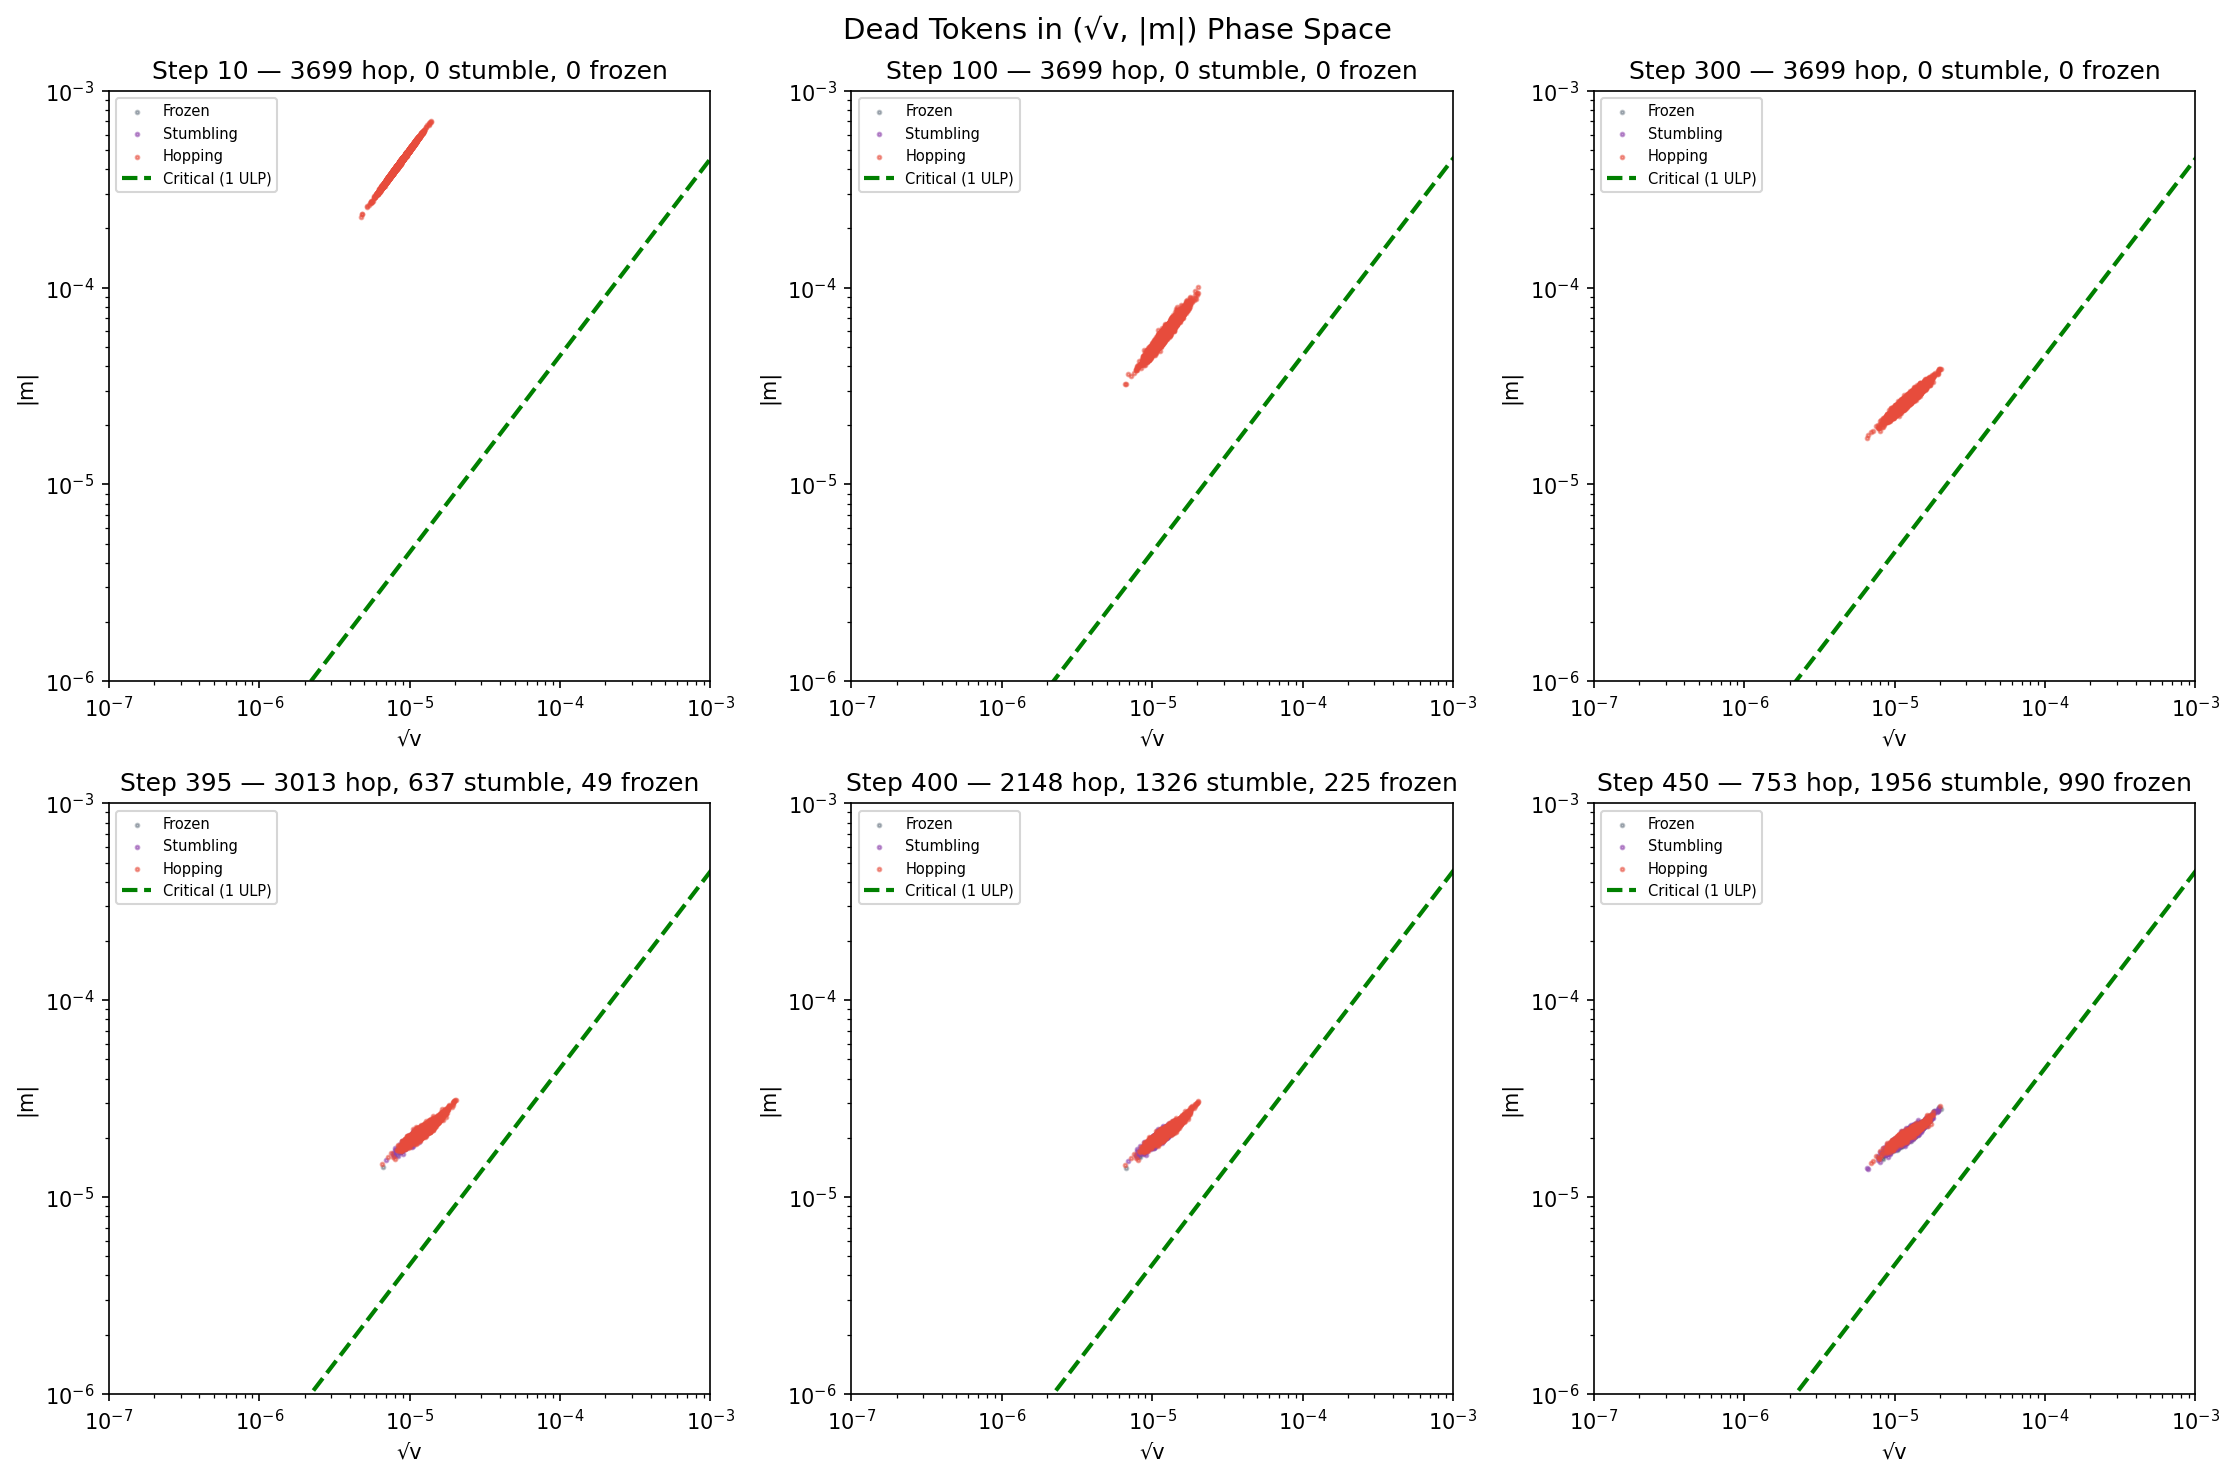

In [6]:
# Representative ULP for plotting the critical curve
ulp_representative = ulp_mean.median().item()
sqrt_v_range = np.logspace(-8, -2, 100)
m_crit_curve = critical_m(sqrt_v_range, ulp_representative)

timesteps_to_plot = [10, 100, 300, 395, 400, 450]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=DPI)
axes = axes.flatten()

for ax, t in zip(axes, timesteps_to_plot):
    t_idx = t - 1  # 0-indexed
    
    sqrt_v_t = sqrt_v[t_idx].numpy()
    m_norm_t = m_norm[t_idx].numpy()
    hopped_t = is_hopping[t_idx].numpy()
    stumbled_t = is_stumbling[t_idx].numpy() & ~is_frozen[t_idx].numpy()
    frozen_t = is_frozen[t_idx].numpy()
    
    # Plot by category
    ax.scatter(sqrt_v_t[frozen_t], m_norm_t[frozen_t], 
               c='#2c3e50', s=3, alpha=0.3, label='Frozen')
    ax.scatter(sqrt_v_t[stumbled_t], m_norm_t[stumbled_t], 
               c='#8e44ad', s=3, alpha=0.5, label='Stumbling')
    ax.scatter(sqrt_v_t[hopped_t], m_norm_t[hopped_t], 
               c='#e74c3c', s=3, alpha=0.5, label='Hopping')
    
    # Critical boundary
    ax.plot(sqrt_v_range, m_crit_curve, 'g--', linewidth=2, label='Critical (1 ULP)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('√v')
    ax.set_ylabel('|m|')
    
    n_hop = hopped_t.sum()
    n_stum = stumbled_t.sum()
    n_froz = frozen_t.sum()
    ax.set_title(f'Step {t} — {n_hop} hop, {n_stum} stumble, {n_froz} frozen')
    ax.legend(loc='upper left', fontsize=7)
    ax.set_xlim(1e-7, 1e-3)
    ax.set_ylim(1e-6, 1e-3)

plt.suptitle('Dead Tokens in (√v, |m|) Phase Space', fontsize=14)
plt.tight_layout()
plt.show()

## Visualization 2: Distance to Critical Boundary Over Time

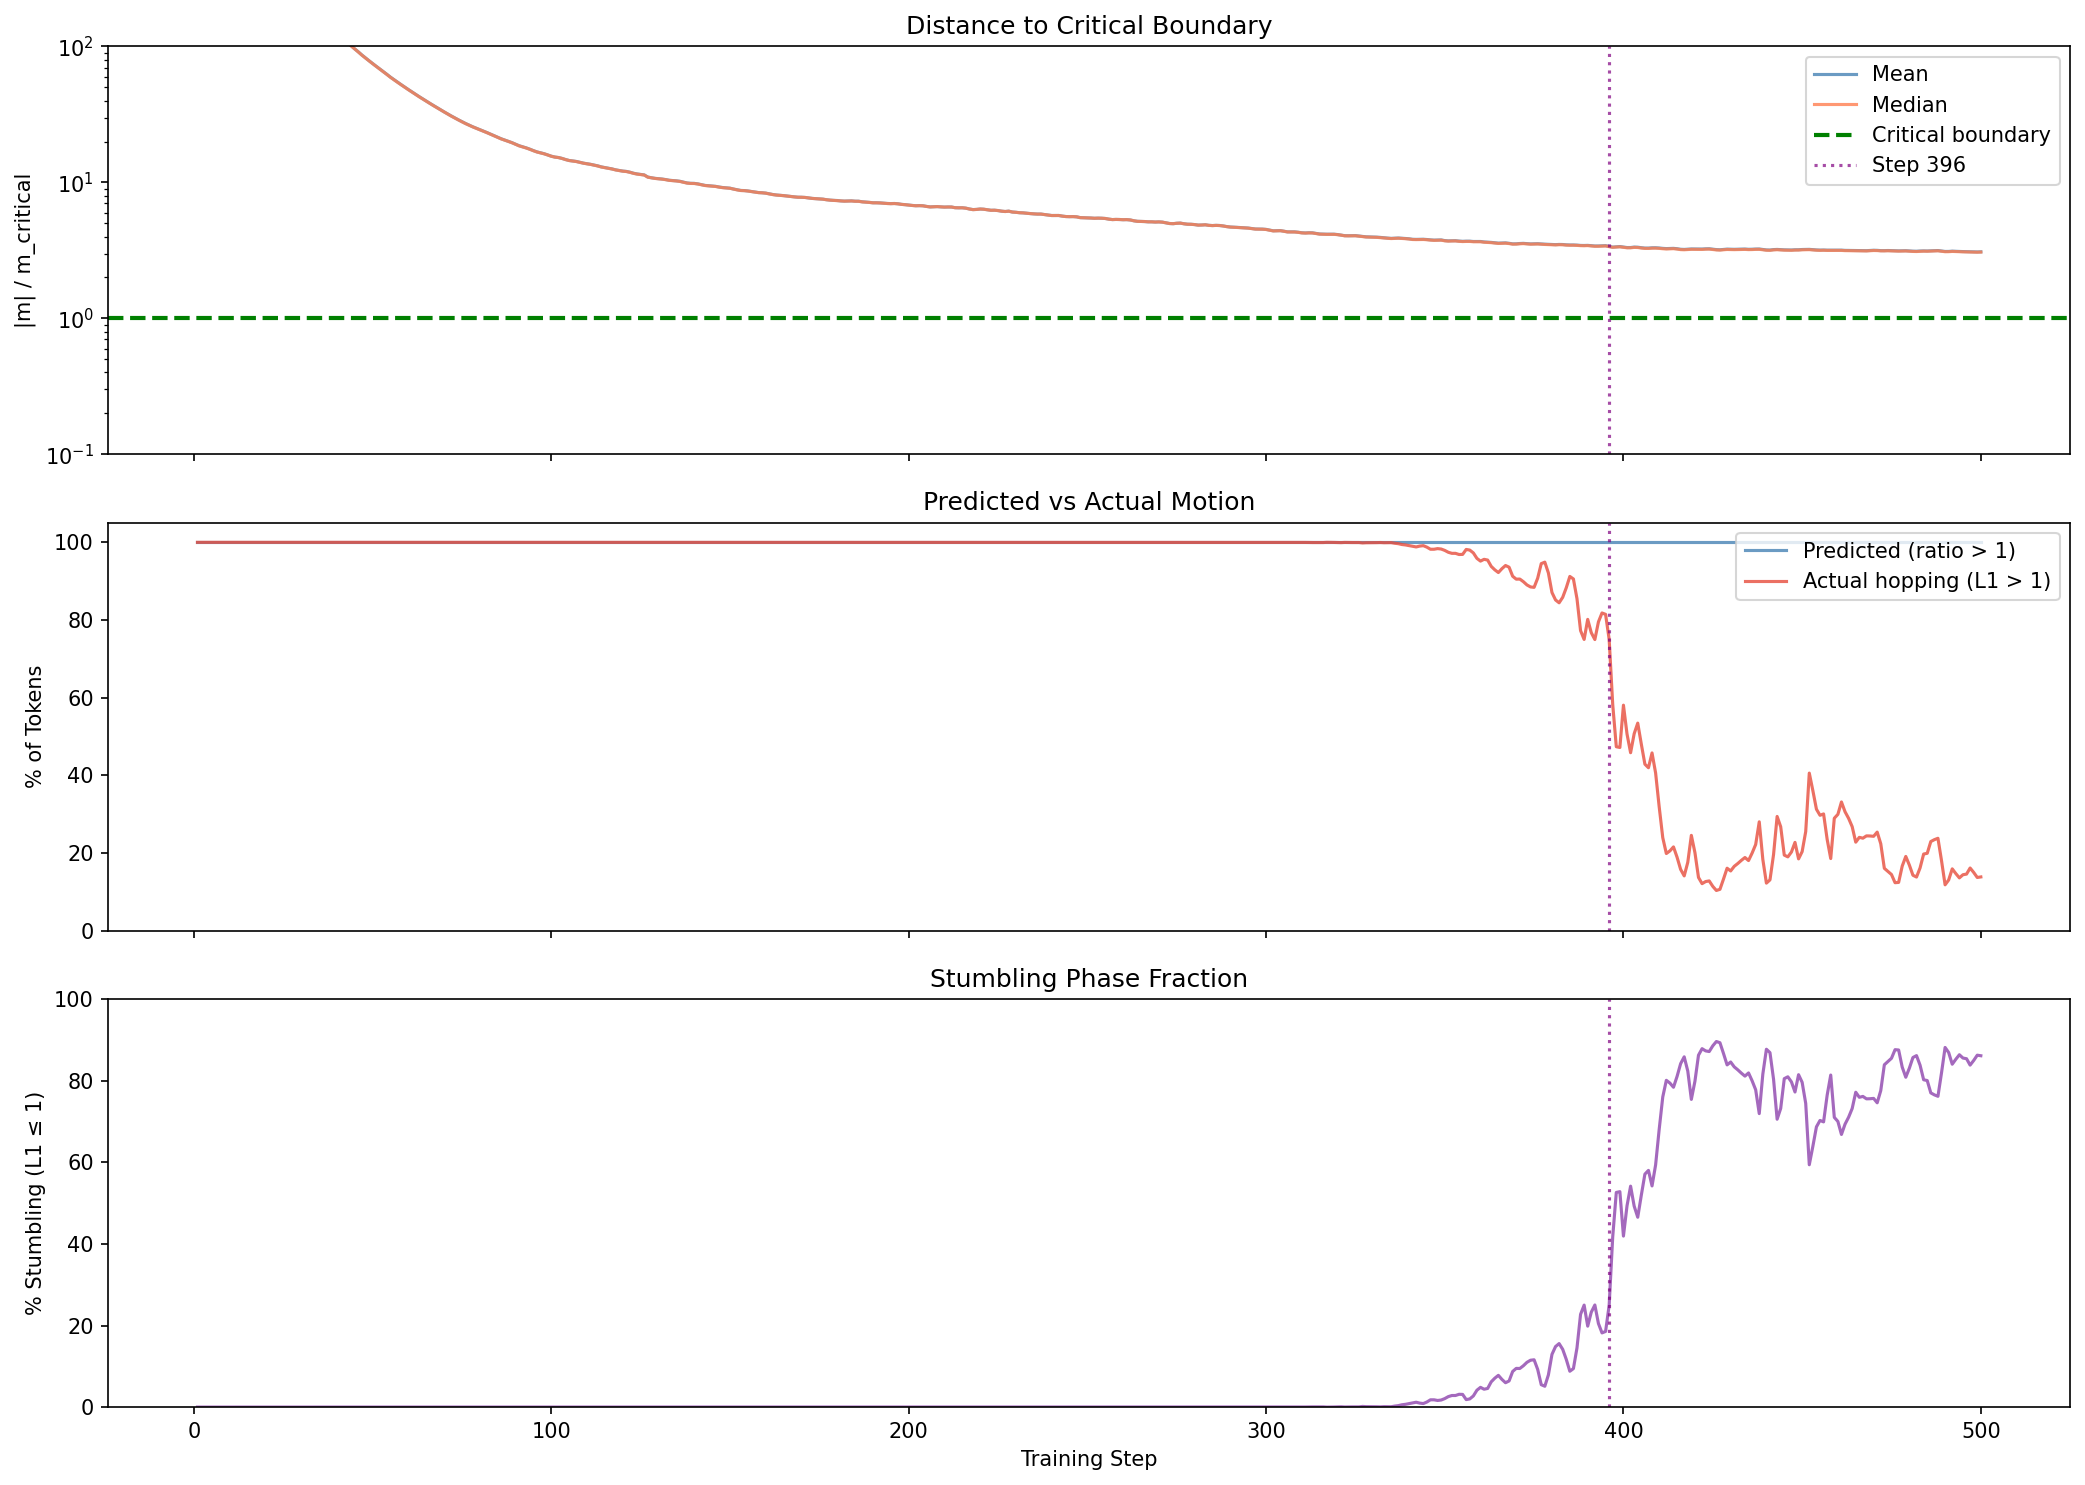

In [7]:
# Summary statistics over time
mean_ratio = ratio_to_critical.mean(dim=1).numpy()
median_ratio = ratio_to_critical.median(dim=1).values.numpy()
frac_above = (ratio_to_critical > 1).float().mean(dim=1).numpy()

# Actual motion statistics
frac_hopping = is_hopping.float().mean(dim=1).numpy()
frac_stumbling = is_stumbling.float().mean(dim=1).numpy()

steps = np.arange(1, n_steps + 1)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), dpi=DPI, sharex=True)

# Top: ratio to critical
ax1 = axes[0]
ax1.semilogy(steps, mean_ratio, label='Mean', color='steelblue', alpha=0.8)
ax1.semilogy(steps, median_ratio, label='Median', color='coral', alpha=0.8)
ax1.axhline(1.0, color='green', linestyle='--', linewidth=2, label='Critical boundary')
ax1.axvline(396, color='purple', linestyle=':', alpha=0.7, label='Step 396')
ax1.set_ylabel('|m| / m_critical')
ax1.set_title('Distance to Critical Boundary')
ax1.legend(loc='upper right')
ax1.set_ylim(0.1, 100)

# Middle: fraction predicted above critical vs actual hopping
ax2 = axes[1]
ax2.plot(steps, frac_above * 100, label='Predicted (ratio > 1)', color='steelblue', alpha=0.8)
ax2.plot(steps, frac_hopping * 100, label='Actual hopping (L1 > 1)', color='#e74c3c', alpha=0.8)
ax2.axvline(396, color='purple', linestyle=':', alpha=0.7)
ax2.set_ylabel('% of Tokens')
ax2.set_title('Predicted vs Actual Motion')
ax2.legend(loc='upper right')
ax2.set_ylim(0, 105)

# Bottom: stumbling fraction
ax3 = axes[2]
ax3.plot(steps, frac_stumbling * 100, color='#8e44ad', alpha=0.8)
ax3.axvline(396, color='purple', linestyle=':', alpha=0.7)
ax3.set_xlabel('Training Step')
ax3.set_ylabel('% Stumbling (L1 ≤ 1)')
ax3.set_title('Stumbling Phase Fraction')
ax3.set_ylim(0, 100)

plt.tight_layout()
plt.show()

## Visualization 3: Gradient Structure at Transition

What do the gradients look like around step 396?

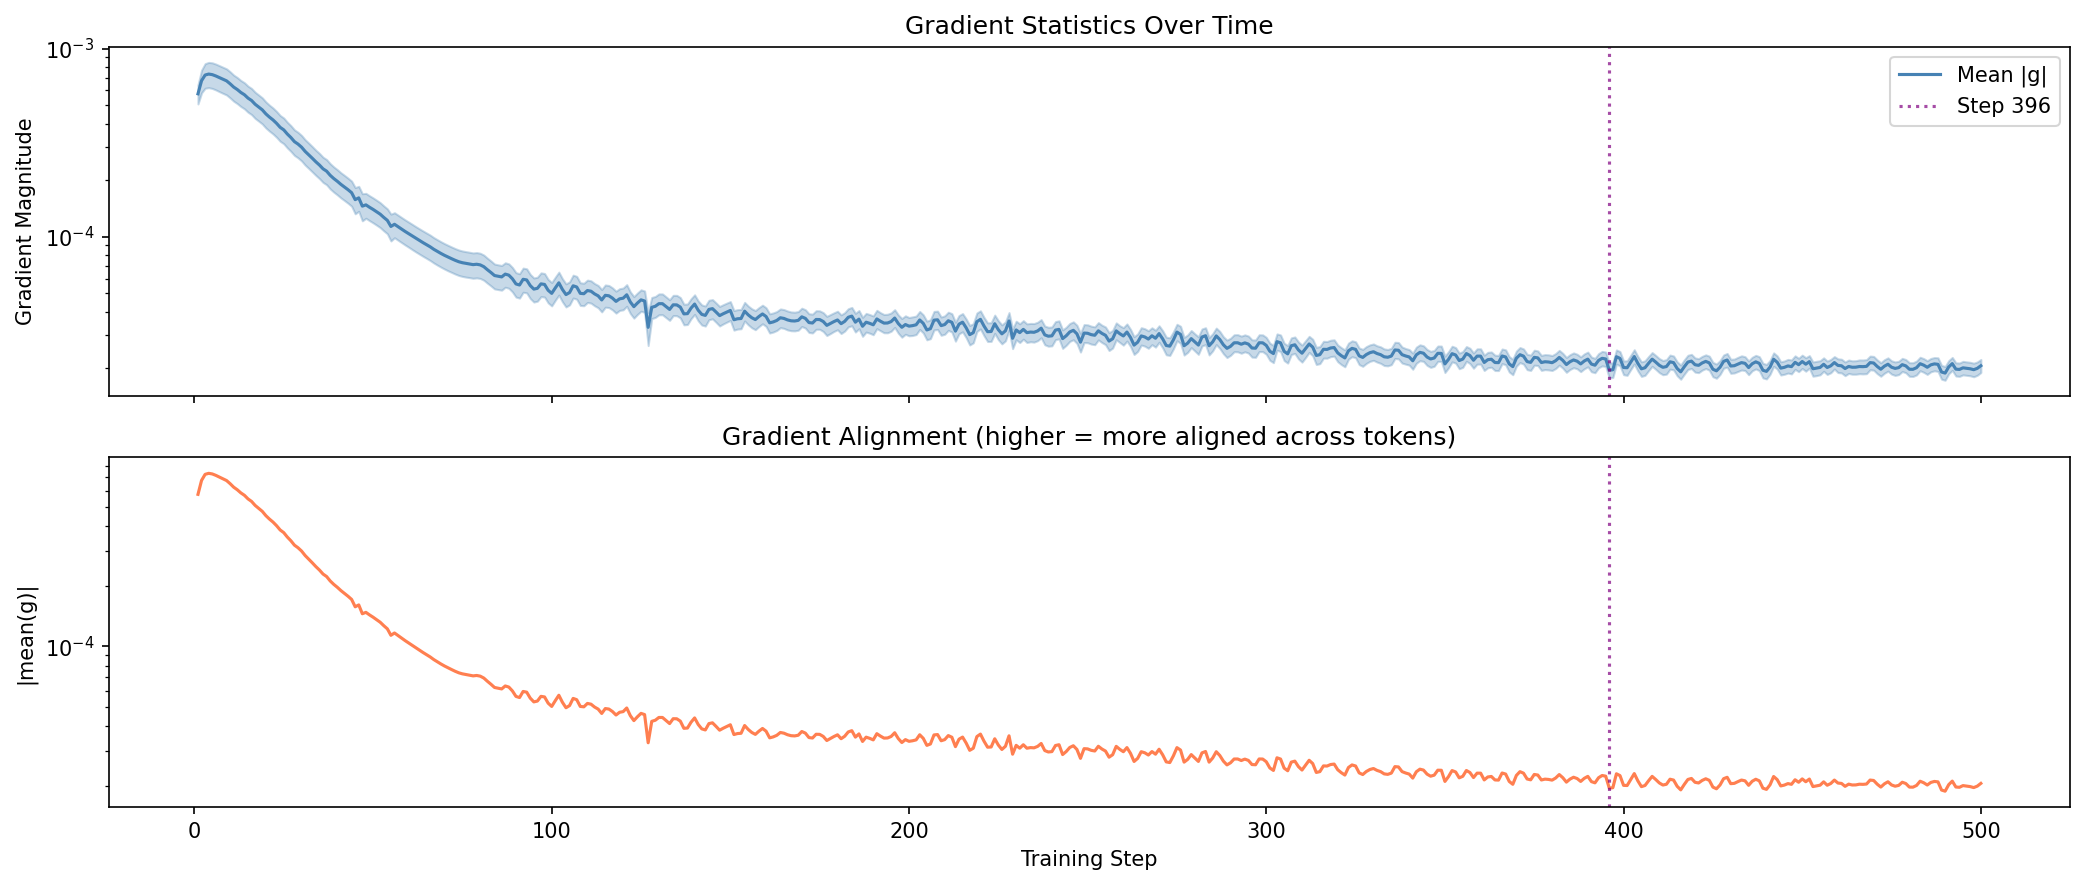

In [8]:
# Gradient statistics over time
g_norm_mean = g_norm.mean(dim=1).numpy()
g_norm_std = g_norm.std(dim=1).numpy()

# Mean gradient direction (L2 normalized)
g_mean_direction = g.mean(dim=1)  # (500, 64) - mean gradient across tokens
g_mean_norm = torch.norm(g_mean_direction, dim=1).numpy()  # How aligned are gradients?

fig, axes = plt.subplots(2, 1, figsize=FIGSIZE_WIDE, dpi=DPI, sharex=True)

ax1 = axes[0]
ax1.semilogy(steps, g_norm_mean, label='Mean |g|', color='steelblue')
ax1.fill_between(steps, 
                  np.maximum(g_norm_mean - g_norm_std, 1e-10), 
                  g_norm_mean + g_norm_std, 
                  alpha=0.3, color='steelblue')
ax1.axvline(396, color='purple', linestyle=':', alpha=0.7, label='Step 396')
ax1.set_ylabel('Gradient Magnitude')
ax1.set_title('Gradient Statistics Over Time')
ax1.legend()

ax2 = axes[1]
ax2.semilogy(steps, g_mean_norm, color='coral')
ax2.axvline(396, color='purple', linestyle=':', alpha=0.7)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('|mean(g)|')
ax2.set_title('Gradient Alignment (higher = more aligned across tokens)')

plt.tight_layout()
plt.show()

## Visualization 4: Token Trajectories Through Phase Space

In [9]:
# Find tokens with different first-stumble times
first_stumble = torch.full((n_tokens,), n_steps, dtype=torch.long)
for token_idx in range(n_tokens):
    stumble_steps = torch.where(is_stumbling[:, token_idx])[0]
    if len(stumble_steps) > 0:
        first_stumble[token_idx] = stumble_steps[0].item()

# Categorize by first stumble time
early = torch.where((first_stumble >= 350) & (first_stumble < 390))[0]
cohort = torch.where((first_stumble >= 395) & (first_stumble <= 400))[0]
late = torch.where(first_stumble > 450)[0]

print(f"Early stumblers (350-390): {len(early)}")
print(f"Cohort (395-400): {len(cohort)}")
print(f"Late stumblers (>450): {len(late)}")

# Sample one from each
sample_tokens = []
labels = []
colors = []

if len(early) > 0:
    sample_tokens.append(early[np.random.randint(len(early))].item())
    labels.append('Early (350-390)')
    colors.append('#3498db')

if len(cohort) > 0:
    sample_tokens.append(cohort[np.random.randint(len(cohort))].item())
    labels.append('Cohort (395-400)')
    colors.append('#9b59b6')

if len(late) > 0:
    sample_tokens.append(late[np.random.randint(len(late))].item())
    labels.append('Late (>450)')
    colors.append('#e74c3c')

Early stumblers (350-390): 1133
Cohort (395-400): 920
Late stumblers (>450): 119


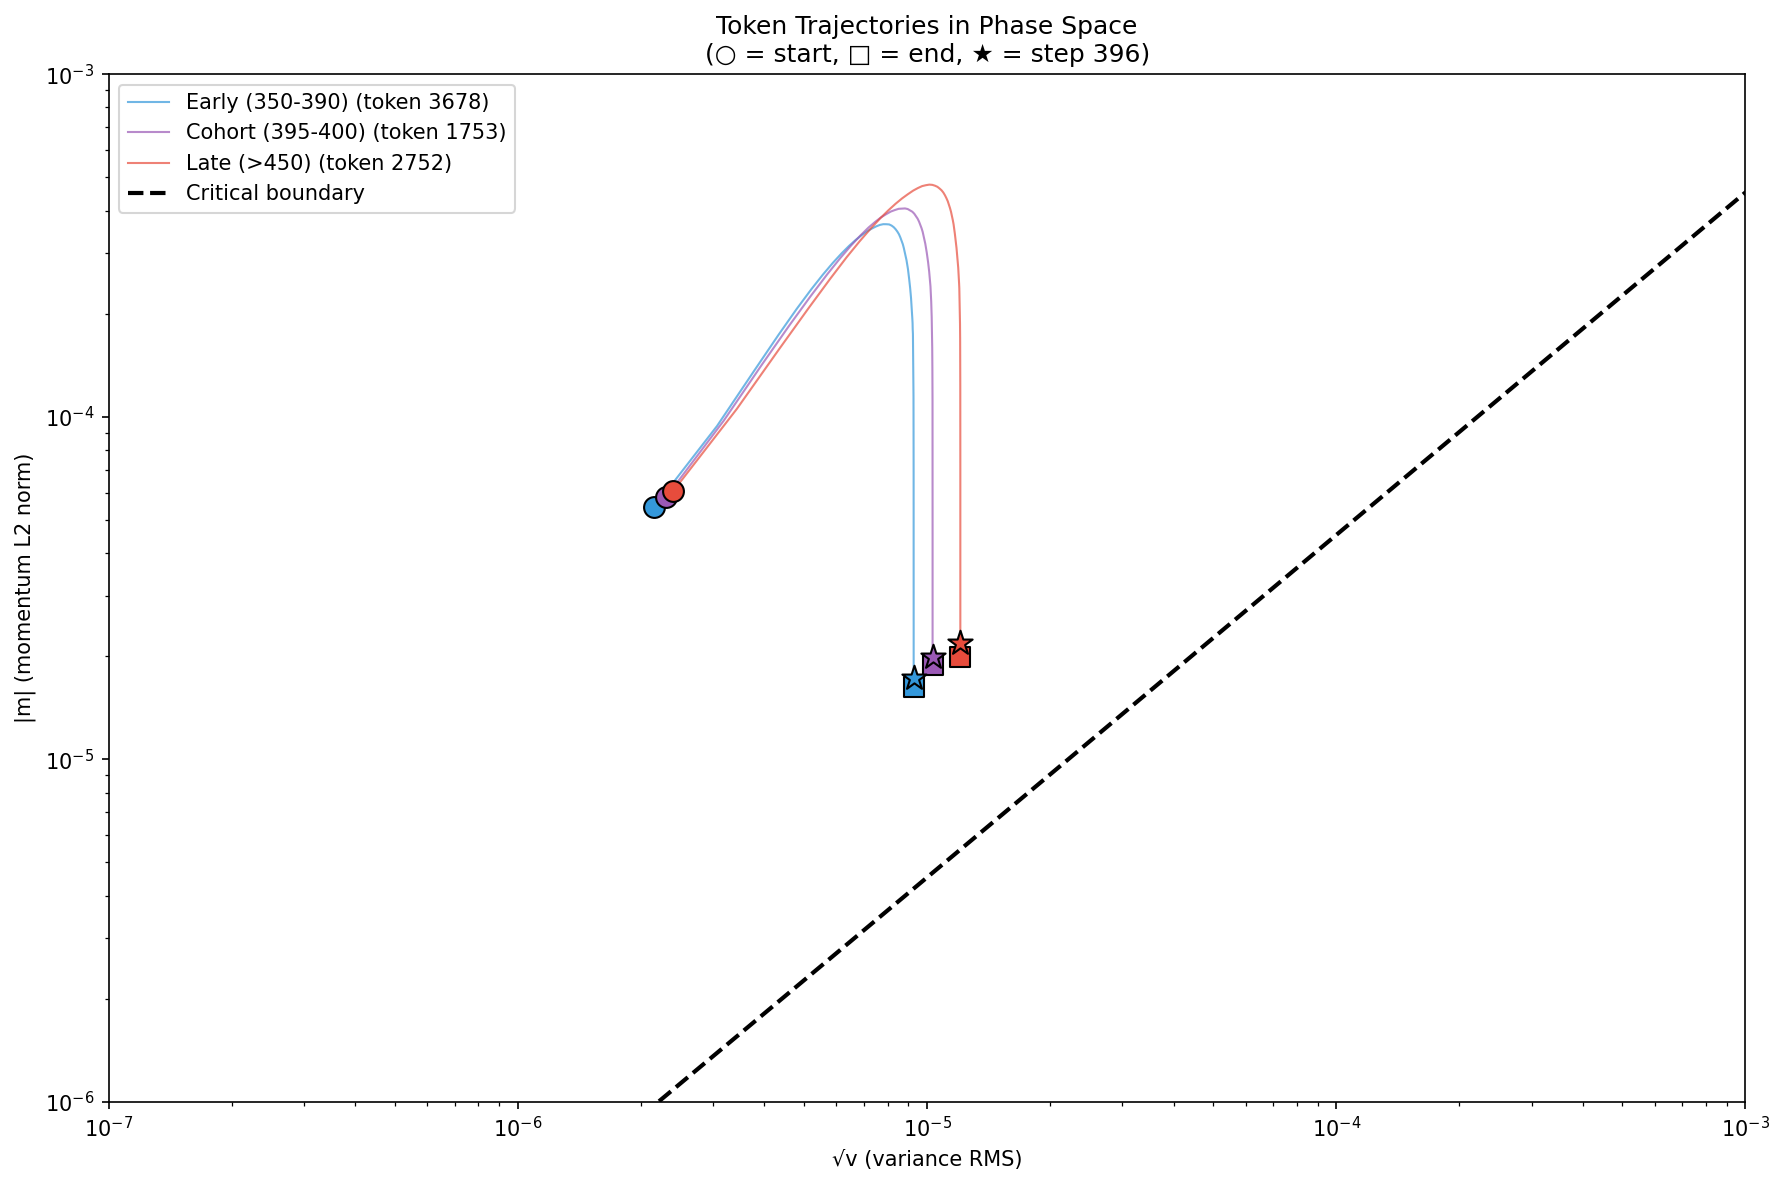

In [10]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

for token_idx, color, label in zip(sample_tokens, colors, labels):
    sqrt_v_traj = sqrt_v[:, token_idx].numpy()
    m_norm_traj = m_norm[:, token_idx].numpy()
    
    # Plot trajectory
    ax.plot(sqrt_v_traj, m_norm_traj, c=color, alpha=0.7, linewidth=1, 
            label=f'{label} (token {token_idx})')
    
    # Mark start and end
    ax.scatter(sqrt_v_traj[0], m_norm_traj[0], c=color, s=100, marker='o', 
               edgecolors='black', zorder=5)
    ax.scatter(sqrt_v_traj[-1], m_norm_traj[-1], c=color, s=100, marker='s', 
               edgecolors='black', zorder=5)
    
    # Mark step 396
    ax.scatter(sqrt_v_traj[395], m_norm_traj[395], c=color, s=150, marker='*',
               edgecolors='black', zorder=6)

# Critical boundary
ax.plot(sqrt_v_range, m_crit_curve, 'k--', linewidth=2, label='Critical boundary')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('√v (variance RMS)')
ax.set_ylabel('|m| (momentum L2 norm)')
ax.set_title('Token Trajectories in Phase Space\n(○ = start, □ = end, ★ = step 396)')
ax.legend(loc='upper left')
ax.set_xlim(1e-7, 1e-3)
ax.set_ylim(1e-6, 1e-3)

plt.tight_layout()
plt.show()

## Visualization 5: Phase Space Density Evolution

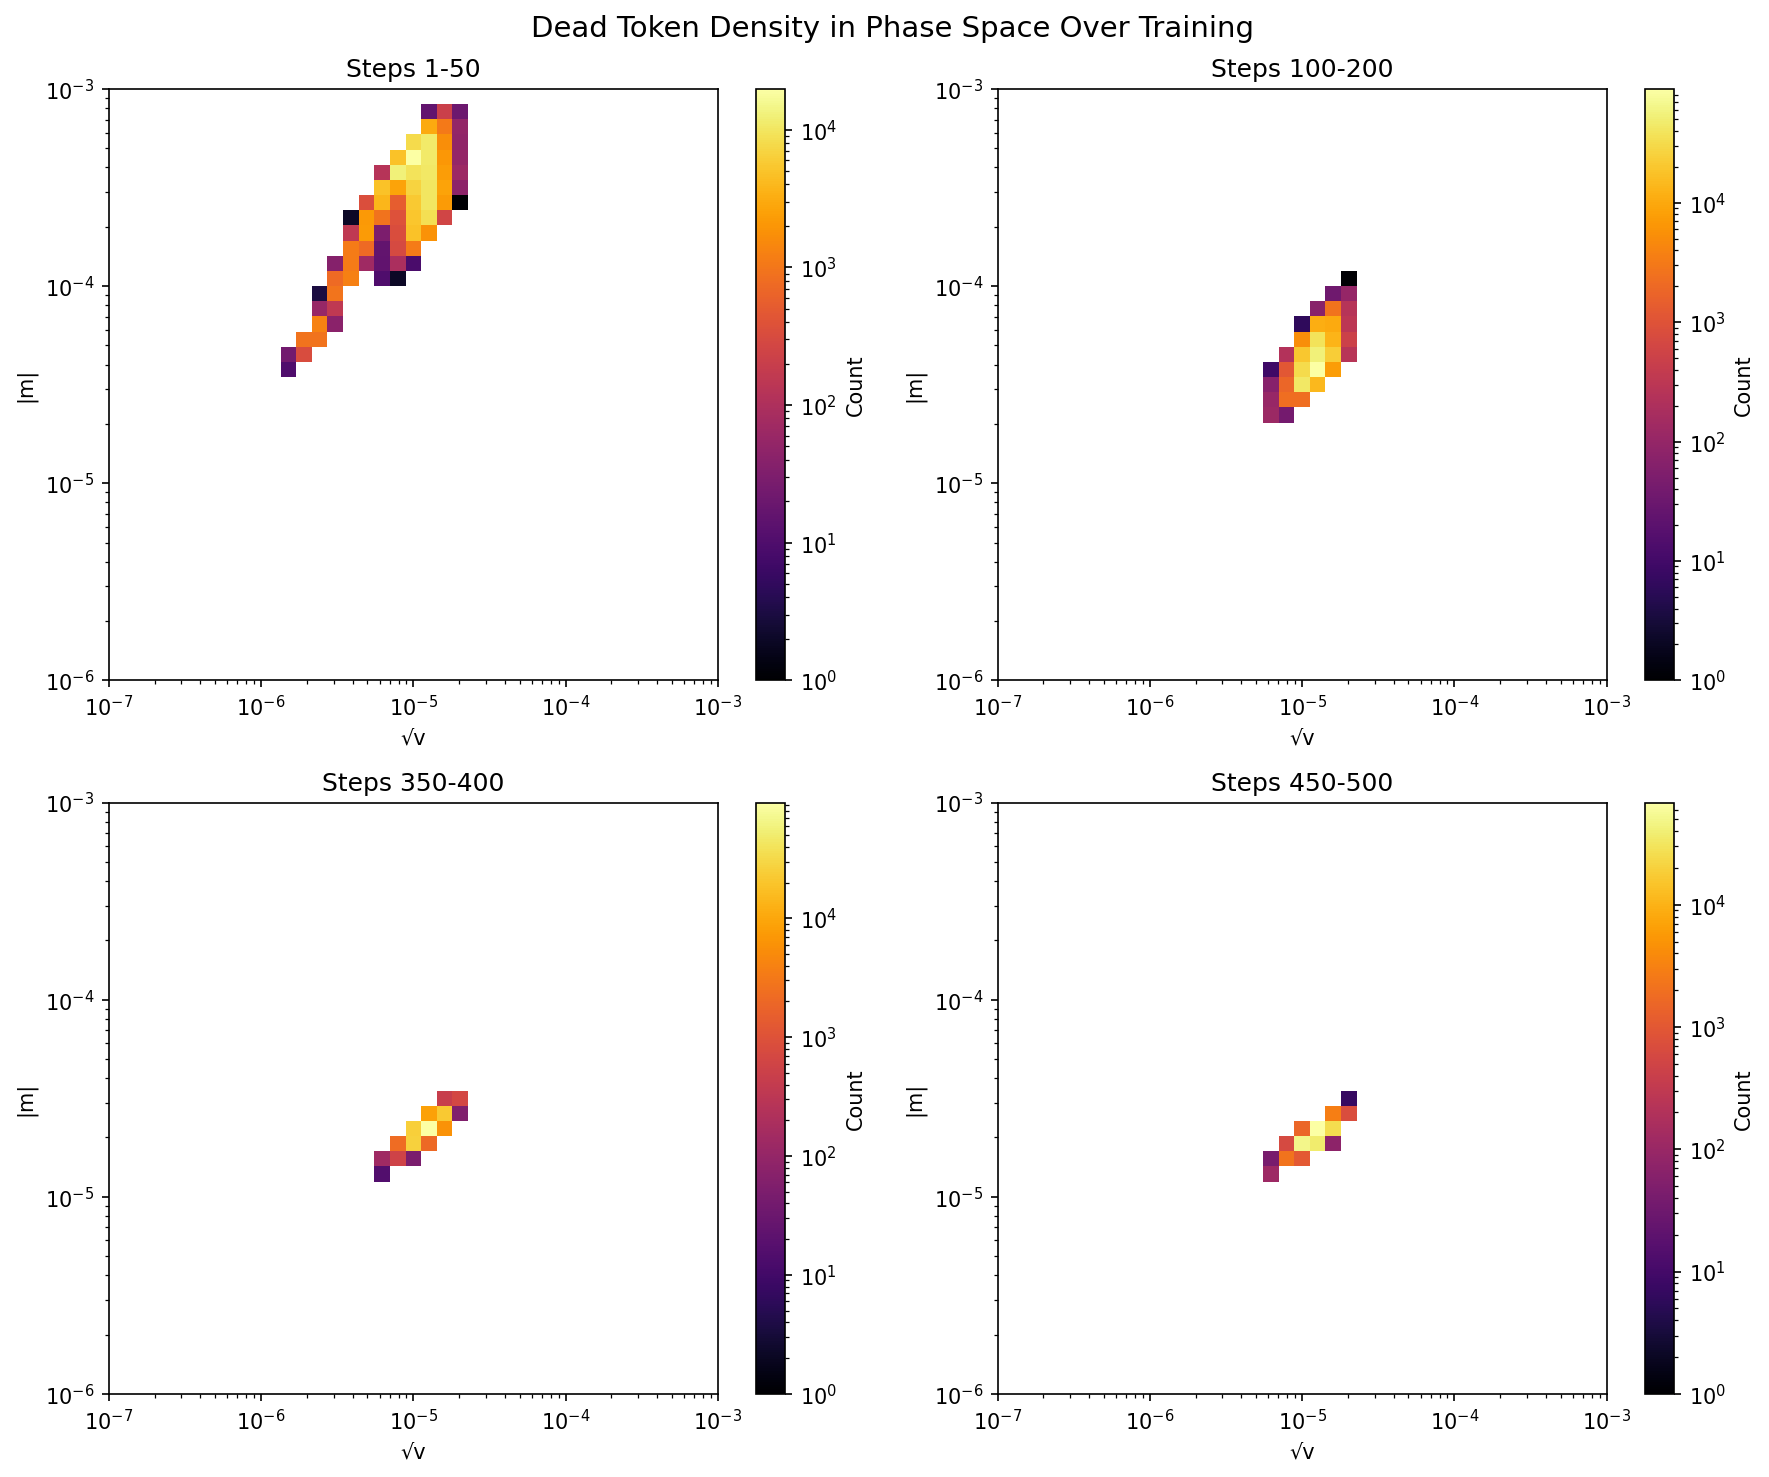

In [11]:
phases = [
    ('Steps 1-50', 0, 50),
    ('Steps 100-200', 99, 200),
    ('Steps 350-400', 349, 400),
    ('Steps 450-500', 449, 500),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=DPI)
axes = axes.flatten()

# Bin edges (log-spaced)
sqrt_v_bins = np.logspace(-7, -3, 40)
m_bins = np.logspace(-6, -3, 40)

for ax, (phase_name, t_start, t_end) in zip(axes, phases):
    # Gather all (sqrt_v, m) points in this time window
    sqrt_v_phase = sqrt_v[t_start:t_end].flatten().numpy()
    m_norm_phase = m_norm[t_start:t_end].flatten().numpy()
    
    # Filter to valid range
    valid = (sqrt_v_phase > 1e-8) & (m_norm_phase > 1e-8)
    sqrt_v_phase = sqrt_v_phase[valid]
    m_norm_phase = m_norm_phase[valid]
    
    # 2D histogram
    h, xedges, yedges = np.histogram2d(
        sqrt_v_phase, m_norm_phase,
        bins=[sqrt_v_bins, m_bins]
    )
    
    # Plot
    im = ax.pcolormesh(xedges, yedges, h.T, cmap='inferno', 
                       norm=LogNorm(vmin=1, vmax=max(h.max(), 10)))
    
    # Critical boundary
    ax.plot(sqrt_v_range, m_crit_curve, 'w--', linewidth=2)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('√v')
    ax.set_ylabel('|m|')
    ax.set_title(phase_name)
    ax.set_xlim(1e-7, 1e-3)
    ax.set_ylim(1e-6, 1e-3)
    plt.colorbar(im, ax=ax, label='Count')

plt.suptitle('Dead Token Density in Phase Space Over Training', fontsize=14)
plt.tight_layout()
plt.show()

## Summary Statistics

In [12]:
print("=" * 60)
print("PHASE SPACE STATISTICS")
print("=" * 60)

# When does median ratio cross below various thresholds?
for thresh in [10, 5, 2, 1]:
    idx = np.where(median_ratio < thresh)[0]
    if len(idx) > 0:
        print(f"Median ratio drops below {thresh} at step {idx[0] + 1}")
    else:
        print(f"Median ratio never drops below {thresh}")

print()

# Comparison at step 396
t_idx = 395  # Step 396, 0-indexed
print(f"At step 396:")
print(f"  Mean ratio to critical: {ratio_to_critical[t_idx].mean():.4f}")
print(f"  Fraction above critical: {(ratio_to_critical[t_idx] > 1).float().mean():.1%}")
print(f"  Actual hopping fraction: {is_hopping[t_idx].float().mean():.1%}")
print(f"  Actual stumbling fraction: {is_stumbling[t_idx].float().mean():.1%}")

print()
print(f"Final state (step 500):")
print(f"  Mean ratio to critical: {ratio_to_critical[-1].mean():.4f}")
print(f"  Fraction above critical: {(ratio_to_critical[-1] > 1).float().mean():.1%}")
print(f"  Actual hopping fraction: {is_hopping[-1].float().mean():.1%}")
print(f"  Actual stumbling fraction: {is_stumbling[-1].float().mean():.1%}")

PHASE SPACE STATISTICS
Median ratio drops below 10 at step 138
Median ratio drops below 5 at step 273
Median ratio never drops below 2
Median ratio never drops below 1

At step 396:
  Mean ratio to critical: 3.3825
  Fraction above critical: 100.0%
  Actual hopping fraction: 75.0%
  Actual stumbling fraction: 25.0%

Final state (step 500):
  Mean ratio to critical: 3.0861
  Fraction above critical: 100.0%
  Actual hopping fraction: 13.8%
  Actual stumbling fraction: 86.2%
